# Buidling an Image Classifier Application with Pytorch

I wanted to teach myself [PyTorch](https://pytorch.org/) and I could think of no better way than building an Image Classifier for **Flowers** from scratch!

The objective of this notebook is to walk through the high level steps of what is required to build an image classifier.

Once this is complete, we will wrap it all up in a **command line application**.

Image data was procured from [here.](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)

**This notebook is NOT intended as an in-depth introduction to Neural Network concepts. Rather, it is mean to illustrate how advanced concepts can be distilled into clean & clear Python using the PyTorch framework. In addition, it is meant to expose the incredibly powerful PyTorch API and how succintly complex neural networks can be created.**


# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 


**The project is broken down into multiple steps:**

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

At the end of this project, we will have an application that can be trained on any set of labeled images.

**It is recommended to run this notebook on a GPU.**

In [1]:
#imports

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from workspace_utils import active_session
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

In order to load data seamlessly, we will use [`torchvision`](http://pytorch.org/docs/0.3.0/torchvision/index.html).

The data can be found [here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz)

The dataset is split into three parts: training, validation, and testing.


For the training, we will apply various transformations to the images. An example of transformations would be:

- Random Scaling
- Cropping
- Flipping

**Why do we apply transformations on the raw images before passing them to the network?**

In order for our network to generalize better, it needs to see various permutations of an image which its associated label. This allows the network to better extract the 'core signal' that makes an image map to a particular label. **It is important to note that transformations of this nature are only applied to the training data and NOT to the testing/validation data.**

Additionally, we will resize our images to 224x224 - this is because we will be using a **pre-trained** network and it requires inputs to be of shape (224,224).


The validation and testing data sets will be used to assess our models performance on data it has never seen! It is sufficient to simply crop theses images to shape (244,24) as required by the pretrained network.

**Additional Information:**

All the pre-trained networks we use in this notebook were trained on the famous [ImageNet dataset](http://www.image-net.org/).

**Important Note:**

All the datasets will needs to have their color channels normalized. This is in order to ensure compatability with the pre-trained networks that expect normalized images.

Means for Color Channels: `[0.485, 0.456, 0.406]`
Std Deviations for Color Channels: `[0.229, 0.224, 0.225]`

These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {'training': transforms.Compose([transforms.RandomRotation(45), transforms.RandomResizedCrop(224), transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(means, stds)]),
                   'validation': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(means, stds)]),
                   'testing': transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(means, stds)])}

image_datasets = {'training': datasets.ImageFolder(train_dir, transform=data_transforms['training']),
                 'validation': datasets.ImageFolder(valid_dir, transform=data_transforms['validation']), 
                 'testing': datasets.ImageFolder(test_dir, transform=data_transforms['testing'])}

dataloaders = {"training": DataLoader(image_datasets['training'], batch_size=32, shuffle=True),
              "validation": DataLoader(image_datasets['validation'], batch_size=32, shuffle=True),
              "testing": DataLoader(image_datasets['testing'], batch_size=32, shuffle=True)}





### Label mapping

Since our flower categories will be encoded with integer labels, we need a way to map these integers back to flower names!

The `cat_to_name.json` file contains these mappings and can be loaded with the `json` module.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We will now build a **Classifier** that will replace the classifer that exists within pre-trained model we will load. Specifically, our classifier will represent a simple feedforward neural network.

Pre-trained Models can be found in `torchvision.models`. More information on pre-trained networks can be found [here](http://pytorch.org/docs/master/torchvision/models.html).

We will break this process up into smaller chunks of code:

1. First, we will write the code for a new Classifier
2. We will then write a function that will save our trained model (new Classifier combined with the pre-trained network)
3. We will then write a function that will load out trained model.
4. We will then write a function that is called `validation`. This function will be called during model training to report statistics on Log Loss, Accuracy etc. This will keep us informed on how the network is progressing.
5. We will write the training function - specifically, we will write a **very flexible** training function that will allow you to experiment with a range of pre-trained networks, parameters etc.

## Global Settings

The `device` variable will be a global variable that represents whether or not the following code should run on a GPU/CPU.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # will be a global variable

In [6]:
device

device(type='cuda', index=0)

# Creating Custom Classifier

In [7]:
class CustomClassifier(nn.Module):
    """
    This is a class representing my Custom Classifier.
    
    This custom classifier will replace the classifiers that are present in pre-trained models.
    
    This custom classifier has a dropout layer between every hidden layer.
    
    Inputs:
        input_size: The dimension of the matrix/feature space that will be fed into the **classifier**.
        output_size: The dimension corresponding the the number of classes - i.e. the output of the classifier.
        hidden_layers: A list representing the dimensions of the intermediate hidden layers.
        drop_p: Probability of an element to be zeroed when passing through a dropout layer.
        
    """
    def __init__(self, input_size, output_size, hidden_layers, drop_p):
        super().__init__()
        
        assert type(input_size) == int, "Enter input size as an integer"
        assert type(output_size) == int, "Enter output size as an integer"
        assert type(hidden_layers) == list, "Enter hidden layers as a list e.g. [512,256,...]"
        assert all(isinstance(x, int) for x in hidden_layers), "Enter hidden layers and integers"
        assert type(drop_p) == list, "Enter dropout ratios per layer as a list"
        assert len(drop_p) == len(hidden_layers), "Please enter a dropout probability per hidden layer"
        assert all(isinstance(x, float) for x in drop_p), "Enter dropout ratios as floats"
        assert len([x for x in drop_p if 0 <= x <= 1]) == len(drop_p), "All drop out ratios must be in [0,1]"
            
        
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        self.layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        
        self.hidden_layers.extend([nn.Linear(h1,h2) for h1,h2 in self.layer_sizes])
        
        # we put this in a seperate module list as the forward pass uses a for-loop to process a sample x.
        self.dropout = nn.ModuleList([nn.Dropout(p=x) for x in drop_p])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
    
    def forward(self, x):
        for index, linear in enumerate(self.hidden_layers):
            x = F.relu(linear(x)) # pass through hidden layer
            x = self.dropout[index](x) # pass through dropout
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1) # straight to NLLLoss

In [8]:
classifier = CustomClassifier(1024, 102, [512,256,128,64], [0.5]*4)

In [9]:
classifier

CustomClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
  )
  (dropout): ModuleList(
    (0): Dropout(p=0.5)
    (1): Dropout(p=0.5)
    (2): Dropout(p=0.5)
    (3): Dropout(p=0.5)
  )
  (output): Linear(in_features=64, out_features=102, bias=True)
)

# Save/Load Model Functions

I will write my save/load model functions now as I know that I will want to save\load my trained model immeadiately after training is complete.

You want to save more information than just the model object. For example, it could be helpful to store the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

`model.class_to_idx = image_datasets['train'].class_to_idx`

A checkpoint should contain all the information you could possibly need to rebuild a model so that it can later be used for inference. 

In the case of loading the model for continue training at a later time, dont forget to save the number of epochs and the optimizer state.

In [10]:
def save_model(model_name, model, training_img_folder, filename):
    """
    This specifiec function is used to save a CustomClassifier object that is used in transfer learning.
    
    Inputs:
        - model_name: Name of the Transfer Learning Architecture (i.e. vgg11)
        - model: Transfer Learning Model
        - training_img_folder: The Training data ImageFolder object
        - filename: Name of saved model file to use. Format: filename_{model_name}.pth
    
    Outputs:
        - None
    """
    
    assert type(training_img_folder) == torchvision.datasets.folder.ImageFolder, "Load the ImageFolder Object associated with training data"
    assert hasattr(model, 'classifier') == True, "Pass a model that has a classifier attribute."
    
        
    clf = model.classifier

    checkpoint = {}

    checkpoint['input_size'] = clf.hidden_layers[0].in_features
    checkpoint['hidden_layers'] = [each.out_features for each in clf.hidden_layers]
    checkpoint['dropout'] = [each.p for each in clf.dropout]
    checkpoint['output_size'] = clf.output.out_features
    checkpoint['state_dict'] = clf.state_dict()
    checkpoint['model_architecture'] = model_name
    checkpoint['class_to_idx'] = training_img_folder.class_to_idx

    if model_name not in filename:
        filename += f'_{model_name}'

    if ".pth" not in filename:
        filename += '.pth'

    torch.save(checkpoint, filename)

    print(f"Model with has been saved to a file called {filename}")

In [11]:
def load_checkpoint(filepath):
    """
    This specific function is used to load a checkpoint that 
    represents a CustomClassifer object that is used in transfer learning.
    
    All params have gradients frozen.
    
    Inputs:
        - Filepath of checkpoint (referring to CustomClassifier object)
    
    Output:
        - model: Transfer Learning model loaded with a CustomClassifier.
    """
    
    checkpoint = torch.load(filepath)
    
    new_classifier = CustomClassifier(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'],
                             checkpoint['dropout'])
    
    #loading classifier state dict
    new_classifier.load_state_dict(checkpoint['state_dict'])
    
    # GPU
    new_classifier.to(device)
    
    # Transfer Architecture type used in creating the classifier
    model_arch = checkpoint['model_architecture']
    
    # Reload that architecture
    model = eval(f"models.{model_arch}(pretrained=True)")
    
    # GPU
    model.to(device)
    
    # Replace default classifier with saved classifier
    model.classifier = new_classifier
    
    # storing the training data class to idx attribute
    model.class_to_idx = checkpoint['class_to_idx']
    
    # freeze entire Network - no more training to occur.
    for param in model.parameters():
        param.requires_grad = False
    
    
    return model

## Validation Function

I will also write my validation function now as I know that I will want to obtain validation statistics throughout the training process.

In [12]:
def validation(model, validationloader, criterion):
    """
    During training, we will look at the performance of our Network with regards to the Validation Set.
    
    Inputs:
        - model: The model that is currently being trained.
        - validationloader: A dataloader object representing the validation data.
        - criterion: The criterion used to train the model.
    """
    validation_loss = 0
    validation_accuracy = 0
    
    model.to(device)
    
    for images, labels in validationloader:
        
        images, labels = images.to(device), labels.to(device)
        
        output = model.forward(images)
        
        validation_loss += criterion(output, labels).item()
        
        probability = torch.exp(output)
        
        equality = (labels.data == probability.max(dim=1)[1]) # recall, max indicies == class label.
        
        validation_accuracy += equality.type(torch.FloatTensor).mean()
    
    validation_loss = validation_loss/len(validationloader)
    validation_accuracy = validation_accuracy/len(validationloader)
    
    return validation_loss, validation_accuracy
        

## Model Training Function

In [13]:
def train(pretrained_network, output_size, optimizer_name, trainloader, validationloader, epochs, learning_rate, print_every, hidden_layers=None):
    """
    All models used with this training function will have a dropout layer between every hidden layer with p=0.1
    
    Inputs:
        - pretrained_network: The string name of the pretrained model to employ i.e. vgg11
        - output_size: The output size of the network - corresponds to the number of classes
        - optimizer_name: The string name of the optimizer to use i.e. Adam
        - trainloader: DataLoader object representing the training data
        - validationloader: DataLoader object representing the validation data
        - epochs: Integer representing the number of epochs the model should run through.
        - learning_rate: Float representing the learning rate i.e. 0.001
        - print_every: Integer representing the frequency of printed statistics i.e. Every 50 iterations
        - hidden_layers
            - Defaults to None, this creates a default CustomClassifier that will be added to the pretraoned model.
            - Otherwise, enter a list representing the hidden layer dimensions to be used for the CustomClassifier.
    Outputs:
        - model: Trained model
        
    """
    
    valid_optimizers = [x for x in dir(optim) if 'lr_scheduler' != x and '__' not in x]
    
    assert type(pretrained_network) == str, f"Please enter pretrained network as a string from: e.g. 'vgg11' "
    assert optimizer_name in valid_optimizers, f"Please enter a optimizer from : {valid_optimizers}"
    assert type(trainloader) == torch.utils.data.dataloader.DataLoader, "Please enter a valid DataLoader object for trainloader"
    assert type(validationloader) == torch.utils.data.dataloader.DataLoader, "Please enter a valid DataLoader object for validationloader"
    assert type(epochs) == int, "Please enter epochs as an integer"
    assert type(print_every) == int, "Please enter print every as an integer"
    
    model = eval(f"models.{pretrained_network}()")
    
    if hasattr(model, 'classifier'):
        model = eval(f"models.{pretrained_network}(pretrained=True)")
    else:
        raise ValueError("Please enter a model that has a classifier attribute.")
    
    model.to(device) # run on GPU
    
    # freeze entire pre-loaded Network.
    for param in model.parameters():
        param.requires_grad = False
    
    ### Building out Custom Classifier Depending on pretrained network
    input_size = list(model.classifier.named_children())[0][-1].in_features # input size to custom network
    
    print(f'The input size to the custom classifer is: {input_size}')
    print()
    
    if hidden_layers:
        
        assert type(hidden_layers) == list, "Enter hidden layers as a list e.g. [512,256,...]"
        
        new_classifier = CustomClassifier(input_size, output_size, hidden_layers, [0.1]*len(hidden_layers))
    else:
        # default hidden layers
        # dropout probs set to 0.1 per layer
        default_layers = [input_size//2,input_size//4]
        new_classifier = CustomClassifier(input_size, output_size, default_layers, [0.1]*len(default_layers))
    
    print(f'The custom classifier is {new_classifier}')
    print()
    
    new_classifier.to(device)
    # update pretrained model to use new classifier - transfer learning step.
    # parameters for this classifier are NOT frozen.
    model.classifier = new_classifier

    criterion = nn.NLLLoss()
    
    #optimizer only concerned with classifier.
    optimizer = eval(f"optim.{optimizer_name}(model.classifier.parameters(), lr={learning_rate})")
    
    steps = 0
    running_loss = 0
    
    for e in range(epochs):
        model.train() # train mode.
        
        for images, labels in trainloader:
            steps += 1
            images, labels = images.to(device), labels.to(device) # GPU copy
            
            # No need for resize as the image is going through a pre-trained network.
            
            optimizer.zero_grad() # zero out the gradient calculations for every batch
            
            output = model.forward(images)
            
            loss = criterion(output, labels)
            
            loss.backward() # backprop over classifier parameters
            
            optimizer.step() # take step
            
            running_loss += loss.item()
            
            if steps % print_every == 0:
                model.eval() # removes dropout
                
                # no gradient tracking here.
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validationloader, criterion)
                    
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss),
                          "Validation Accuracy: {:.3f}".format(accuracy))
                
                running_loss = 0
                
                model.train() # enter training mode again.
    
    return model, pretrained_network

In [14]:
with active_session():
    trained_model, transfer_model_name = train('vgg11', 102, 'Adam', dataloaders['training'], dataloaders['validation'], 5, 0.001, 50)
    save_model(transfer_model_name, trained_model, image_datasets['training'],'trained_model_v1')

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.torch/models/vgg11-bbd30ac9.pth
100%|██████████| 531456000/531456000 [00:21<00:00, 24370112.69it/s]


The input size to the custom classifer is: 25088

The custom classifier is CustomClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=25088, out_features=12544, bias=True)
    (1): Linear(in_features=12544, out_features=6272, bias=True)
  )
  (dropout): ModuleList(
    (0): Dropout(p=0.1)
    (1): Dropout(p=0.1)
  )
  (output): Linear(in_features=6272, out_features=102, bias=True)
)

Epoch: 1/5..  Training Loss: 5.685..  Validation Loss: 3.371..  Validation Accuracy: 0.259
Epoch: 1/5..  Training Loss: 3.088..  Validation Loss: 2.412..  Validation Accuracy: 0.397
Epoch: 1/5..  Training Loss: 2.540..  Validation Loss: 1.793..  Validation Accuracy: 0.520
Epoch: 1/5..  Training Loss: 2.127..  Validation Loss: 1.688..  Validation Accuracy: 0.563
Epoch: 2/5..  Training Loss: 2.029..  Validation Loss: 1.344..  Validation Accuracy: 0.621
Epoch: 2/5..  Training Loss: 1.864..  Validation Loss: 1.199..  Validation Accuracy: 0.650
Epoch: 2/5..  Training Loss: 1.848..  Validation 

## Testing your network

We will now test our trained model using the test data! This will give us a good idea about the general performance of out model.

To do this, we will first load up our model - recall, a model can take hours to train. As such, we saved it to disk in the `save_model` function.

# Loading Trainined Model

In [15]:
loaded_model = load_checkpoint('trained_model_v1_vgg11.pth')

In [16]:
def test_model(model, testloader):
    """
    This function will take a pretrained model and a dataloader representing the training data and report accuracy.
    
    Inputs:
        - model: pretrained model
        - testloader: DataLoader object representing testing data.
    
    Outputs:
        - None
    """
    model.eval()
    
    test_accuracy = 0
    
    model.to(device)
    
    with torch.no_grad():
        
        for images, labels in testloader:

            images, labels = images.to(device), labels.to(device)

            output = model.forward(images)

            probability = torch.exp(output)

            equality = (labels.data == probability.max(dim=1)[1]) # recall, max indicies == class label.

            test_accuracy += equality.type(torch.FloatTensor).mean()
    
    test_accuracy = test_accuracy/len(testloader)
    
    return test_accuracy
        

In [17]:
test_acc = test_model(loaded_model, dataloaders['testing'])

In [18]:
# 78% Accuracy
test_acc.item()*100

77.75176763534546

# Let's make predictions (inference).

We can write a function called `predict` that will allow us to make predictions using our model and a given image path!

In essence, our model takes a picture of a flower and returns the classification of that flower.

In my example below, I return the top 5 potential classifications and their associated probabilities.

**Note:** Recall that any new images passed into our model for inference will first need to be pre-processed!


## Image Preprocessing

We will use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)).

This function will be called `process_image` and return an `Image` object. It is this object that is passed to our model!

**Important Note:**

PyTorch expects the color channel to be in the first dimension, however, the `PIL` image object, when casted to a numpy array, returns the color channels in the third dimension. Simply transpose the dimensions to get the correct representation. Retain the order of the other two dimensions.

In [21]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch model, returns an Numpy array

    Inputs:
        - image_path: path to image to be processed
    
    Returns:
        - image: The processed Image Object.
    '''
    image = Image.open(image_path)

    original_width, original_height = image.size

    shortest_side = min(original_width, original_height)

    # Maintain Aspect Ratio
    new_width, new_height = int((original_width/shortest_side)*256), int((original_height/shortest_side)*256)
    image = image.resize((new_width, new_height))
    
    width, height = image.size
    
    #Center Cut
    center_width = 224
    center_height = 224
    
    left_side_move = (width - center_width)/2
    top_side_move = (height - center_height)/2
    right_side_move = (width + center_width)/2
    bottom_side_move = (height + center_height)/2
    
    # Crop according to these pixel locations that make a box.
    image = image.crop((left_side_move, top_side_move, right_side_move, bottom_side_move))

    # 0-1 range color channels.
    image = np.array(image)
    image = image/255 # broadcasting

    # Match Model Normalization Criteria
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = (image - mean) / std # broadcasting

    # Reordering
    image = image.transpose((2, 0, 1))

    return image

In [22]:
process_image('flowers/train/1/image_06734.jpg').shape

(3, 224, 224)

## Helper Function

Here is a function that will convert a PyTorch tensor and display it as an Image. This will let us trouble shoot our `process_image` function and ensure that it is working correctly. When passing an image object, we should return the original image (dimensions) with exception of the cropped out portions.

In [23]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

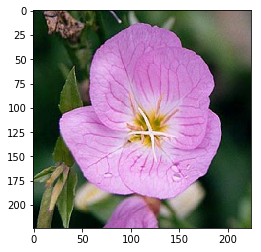

In [24]:
imshow(process_image('flowers/train/1/image_06734.jpg'))

## Lets make the predicition function!

In [25]:
def predict(image_path, model, topk=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    
    Inputs:
        - image_path: path to image that will be passed to the model.
        - model: pretrained model
        - topk: Will display top k probabilities for a given image. Defaults to k=5.
    '''
    
    #single image - need to insert a batch axis for model compatibility, hence we use unsqueeze on dimension 0.
    image = torch.tensor(process_image(image_path)).type(torch.FloatTensor).unsqueeze_(0).to(device)
    
    model.to(device)
    
    #turn off dropout
    model.eval()
    
    # reverse class to idx dict so that an index returns a class
    class_map = {v:k for k,v in model.class_to_idx.items()}
    
    # no gradient tracking
    with torch.no_grad():
        
        output = model.forward(image)
        
        probability = torch.exp(output)
        
        top_probs, indicies = probability.topk(topk, dim=1)
    
    classes = [class_map[x] for x in indicies.squeeze().tolist()]
    
    classes, top_probs = zip(*sorted(zip(classes,top_probs.squeeze().tolist()), reverse=True, key=lambda x: x[1]))
    
    return top_probs, classes

In [30]:
# this is a file mapping to stemless gentian.
stemless_gentian_path = 'flowers/train/28/image_05212.jpg'
probs, classes= predict(stemless_gentian_path, loaded_model)

## Sanity Checking

We know have our model! WOOHOOO!!

BUT - we should check to make sure it makes sense.

It is important to note that even if testing accuracy is high, we should try to get visual confirmation so that were ensure there are not any blatant bugs!

Let's plot the probabilities for the top 5 classes as a bar graph, along with the input image.

In [31]:
def display_results(probs, classes):
    """
    Create a horizontal bar plot displaying the results of a prediction.
    
    Inputs:
        - probs: list representing probabilities
        - classes: list representing class indicies.
        
        probs and classes hould correspond 1-1
    
    Outputs:
        Horizontal Barplot
    """
    
    assert len(probs) == len(classes), "probs should match classes in 1-1 manner"
    
    objects = [cat_to_name[x] for x in list(classes)]
    y_pos = np.arange(len(objects))
    performance = probs

    plt.barh(y_pos, performance, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.xlabel('Probability')
    plt.title(objects[0])

    return plt.show()

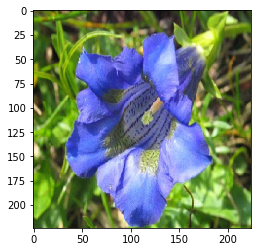

In [32]:
imshow(process_image(stemless_gentian_path))

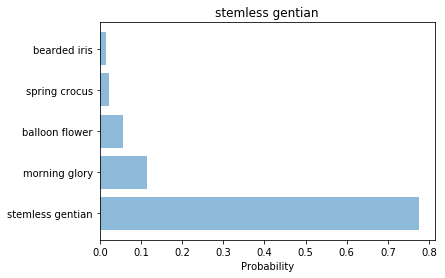

In [33]:
display_results(probs, classes)